# Model Deployment
The purpose of the model deployment phase in a model development process is to take a trained and validated machine learning model and make it available for use in a real-world environment. This phase involves integrating the model into production systems so it can generate predictions on new, unseen data. The main goals are:

- Operationalizing the model so it can be accessed by end-users, applications, or business processes.
- Ensuring the model runs efficiently, reliably, and securely in the target environment.
- Monitoring the model’s performance over time to detect data drift or performance degradation.
- Enabling updates, retraining, or rollback as needed based on new data or requirements.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import rich

In [2]:
version_tag = "dev"

## Load Data And Base Model

In [3]:
## Load data
input_folder = "../.local/analysis_pipeline/data_exploration"
inference_data = pd.read_parquet(f"{input_folder}/inference_data_{version_tag}.parquet")

## Load model
from xgboost import XGBRegressor
input_folder = "../.local/analysis_pipeline/model_selection"
model = XGBRegressor()
model.load_model(f"{input_folder}/xgb_tweedie_model_{version_tag}.json")

## Predict On The Inference Data

In [10]:
# Import xgboost for model prediction (not strictly needed for XGBRegressor, but kept for reference)
import xgboost as xgb

# Define the list of predictor variables (should match those used in model training)
veh_pred_lst = ['veh_value', 'veh_body', 'veh_age', 'engine_type', 'max_power', 'veh_color']
policy_pred_lst = ['gender', 'agecat', 'e_bill' ]
driving_behavior_pred_lst = ['area', 'time_of_week_driven', 'time_driven']
demo_pred_lst = ['marital_status', 'high_education_ind', 'credit_score', 'driving_history_score']
pred_lst = veh_pred_lst + policy_pred_lst + driving_behavior_pred_lst + demo_pred_lst

# Select the predictor columns from the inference data
X = inference_data[pred_lst].copy()

# Convert object columns to 'category' dtype if needed (for compatibility, especially if used during training)
for col in pred_lst:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# Predict using the loaded XGBRegressor model
pred = model.predict(X)

# Store the predictions in a new column in the inference_data DataFrame
inference_data['xgb_tweedie_pred'] = pred

## Sign risk levels to the quotes

In [11]:
# Ensure the parent directory is in the path for module import
import sys
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import PredictivenessCheck

# Select training samples for predictiveness check
data = inference_data

# Define variables
exp_var = 'veh_cnt'
pred_var = 'xgb_tweedie_pred'
var_1 = 'xgb_tweedie_pred'
var_2 = None
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

# Assign risk bins to quotes in the inference data
pc.binning(nbins=nbins)
processed_inference_data = pc.binned_data

## Inference Via Top Reasons


--- Predictiveness Plot for veh_value ---


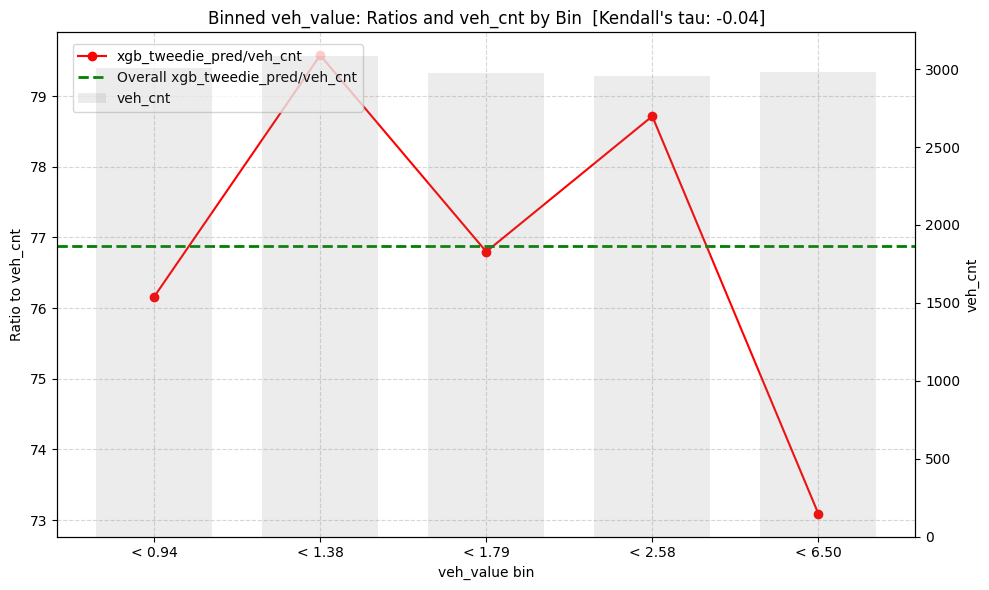


--- Predictiveness Plot for veh_body ---


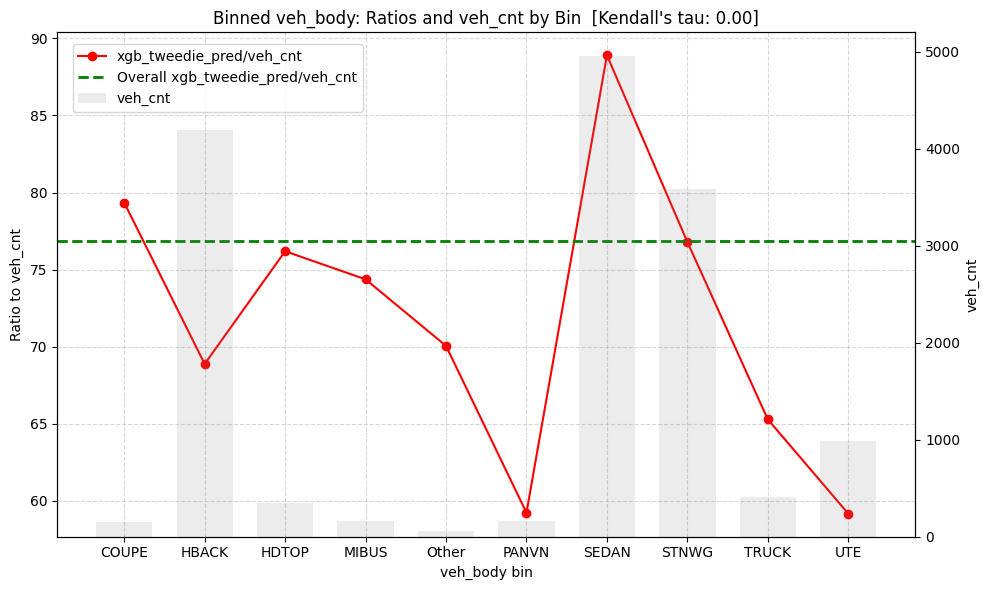


--- Predictiveness Plot for veh_age ---


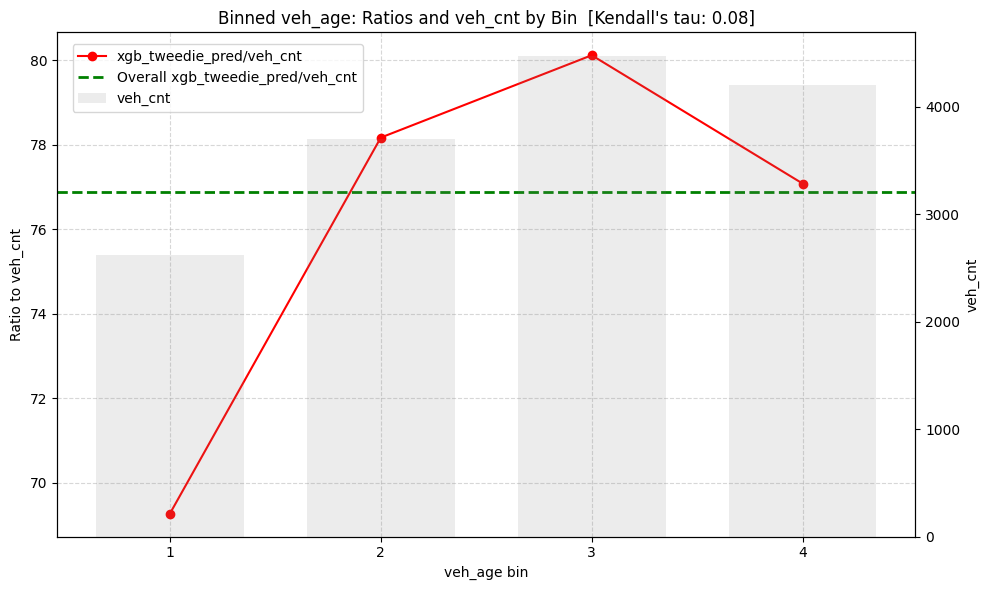


--- Predictiveness Plot for engine_type ---


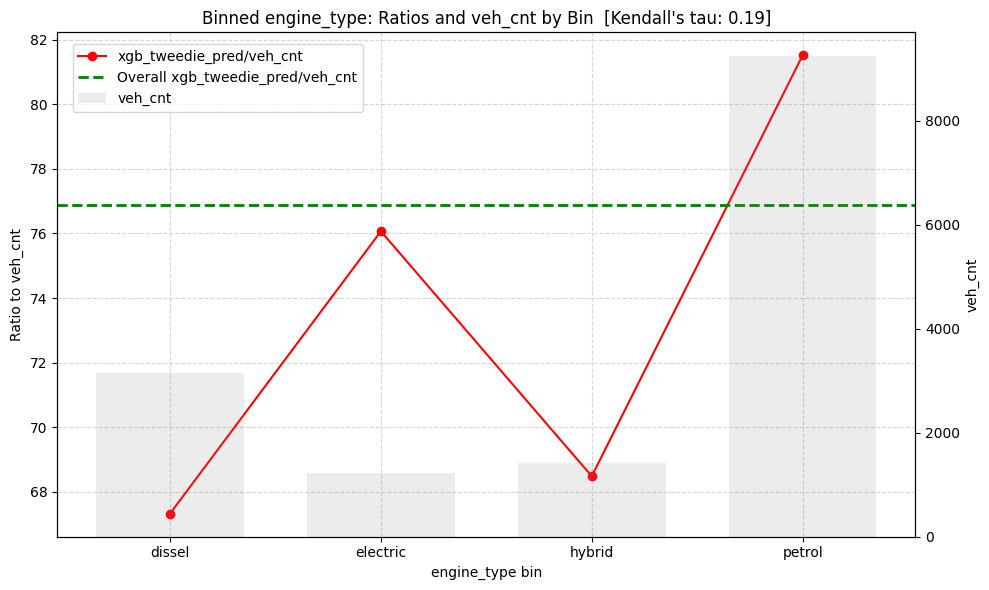


--- Predictiveness Plot for max_power ---


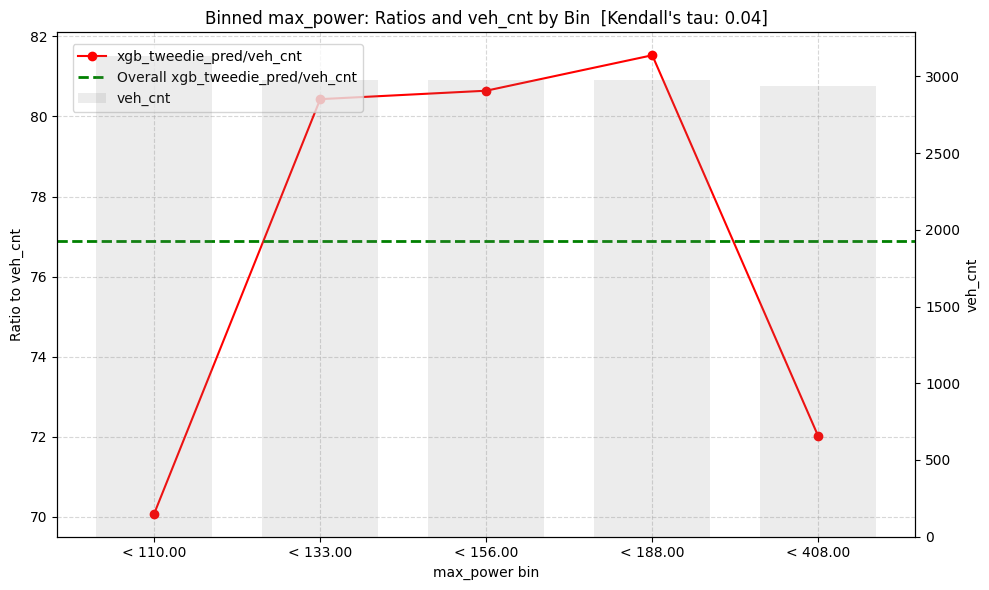


--- Predictiveness Plot for veh_color ---


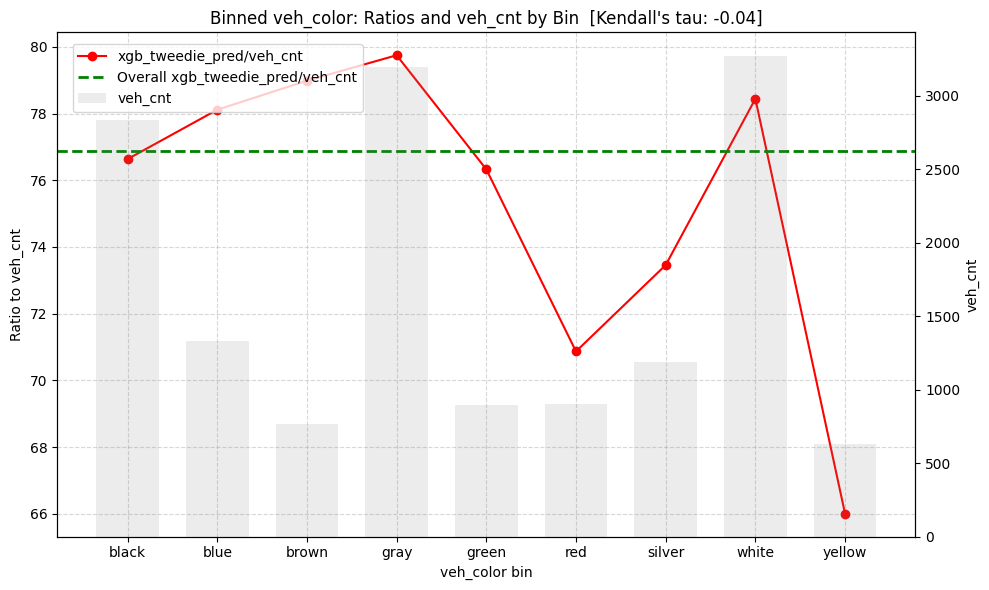


--- Predictiveness Plot for gender ---


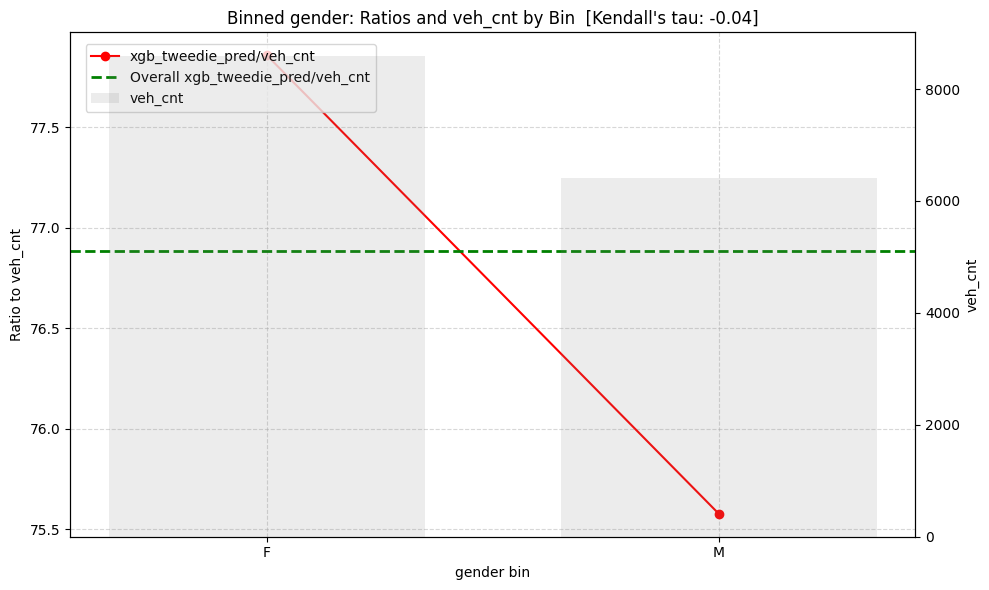


--- Predictiveness Plot for agecat ---


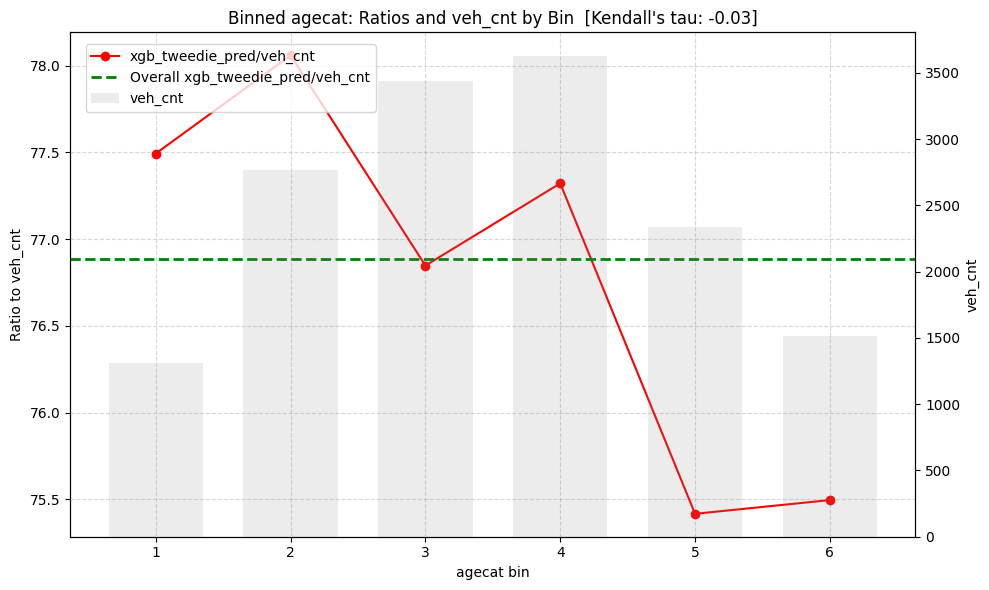


--- Predictiveness Plot for e_bill ---


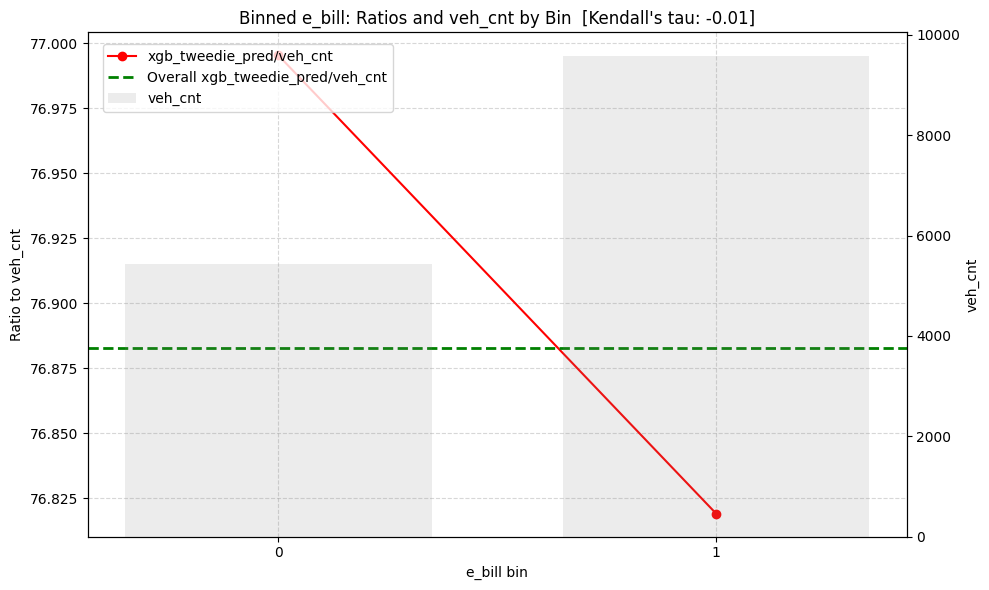


--- Predictiveness Plot for area ---


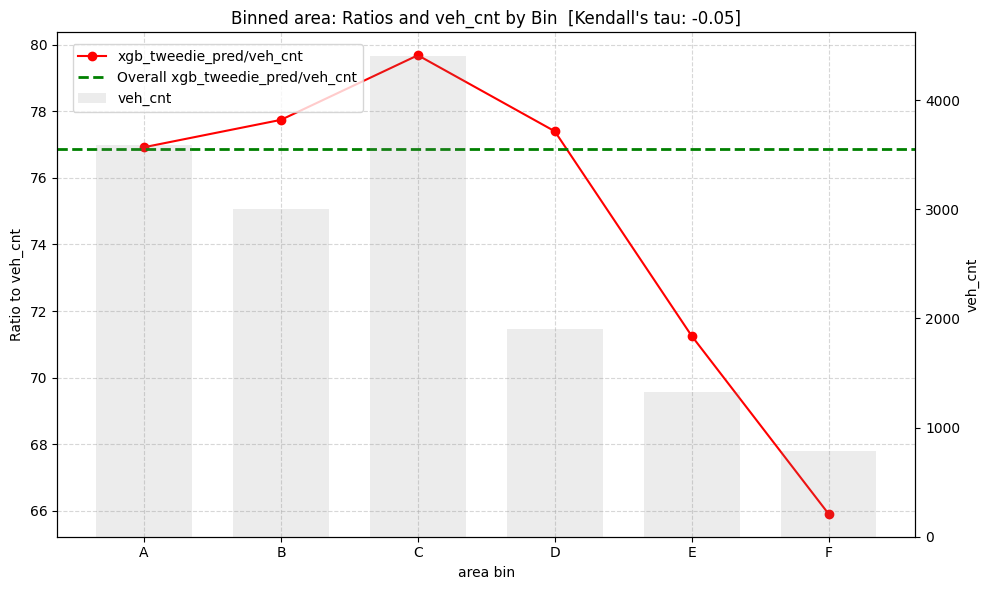


--- Predictiveness Plot for time_of_week_driven ---


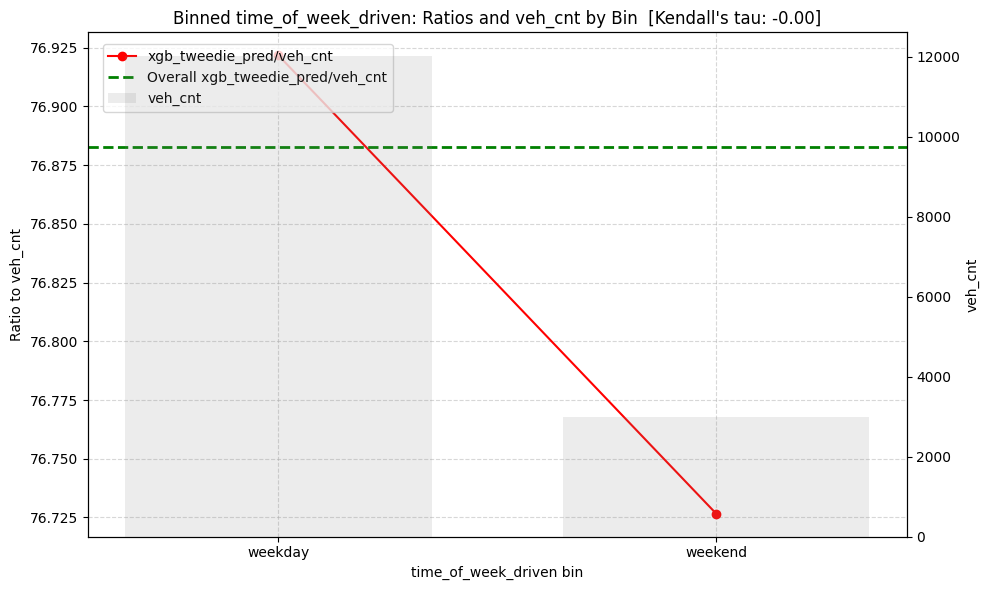


--- Predictiveness Plot for time_driven ---


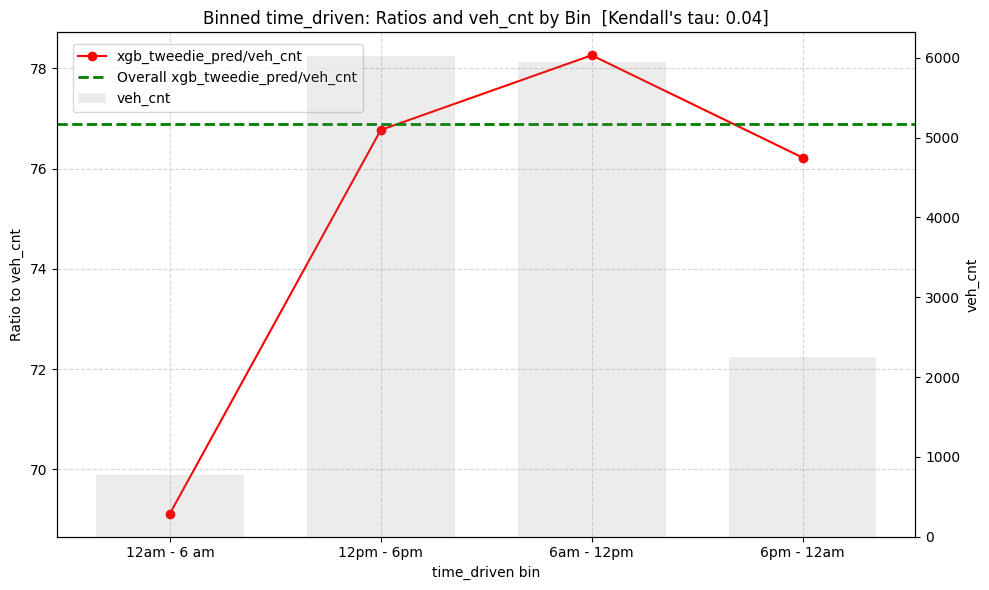


--- Predictiveness Plot for marital_status ---


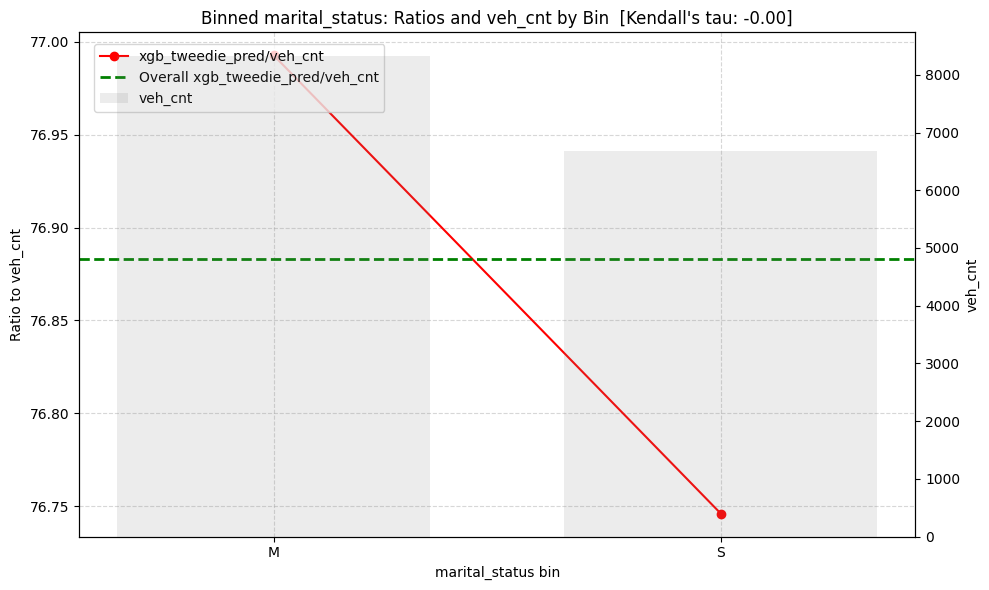


--- Predictiveness Plot for high_education_ind ---


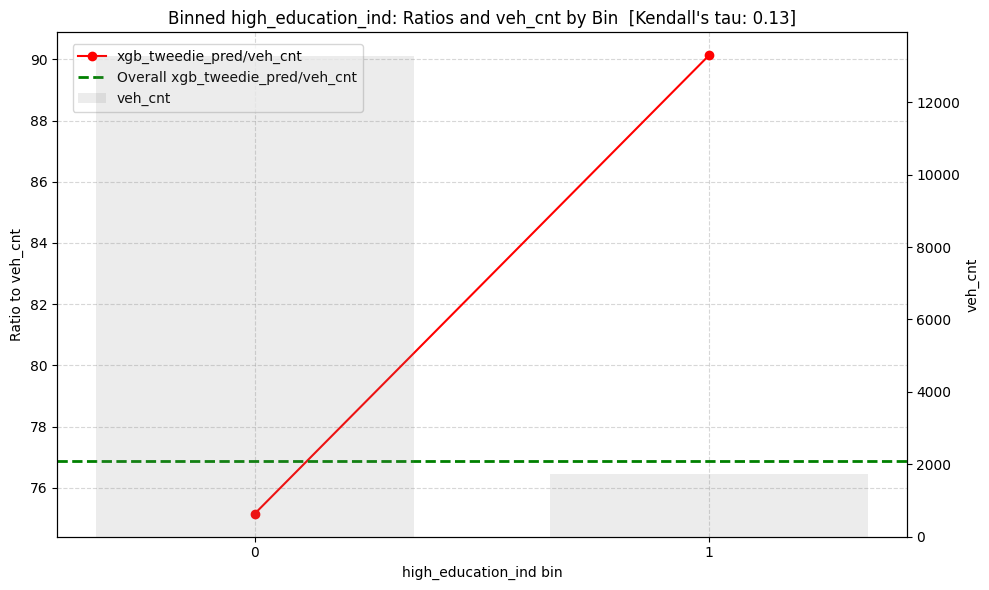


--- Predictiveness Plot for credit_score ---


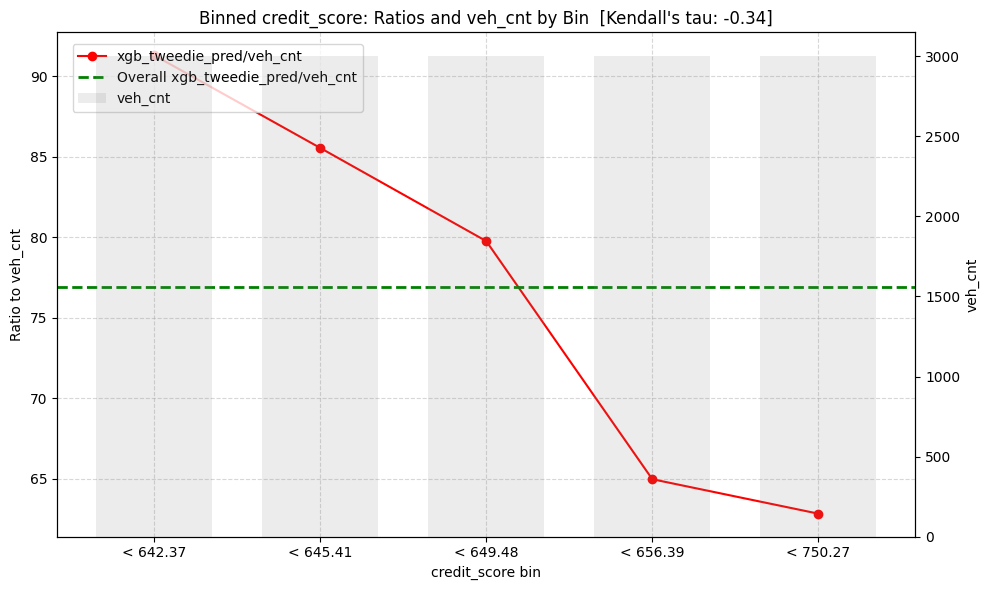


--- Predictiveness Plot for driving_history_score ---


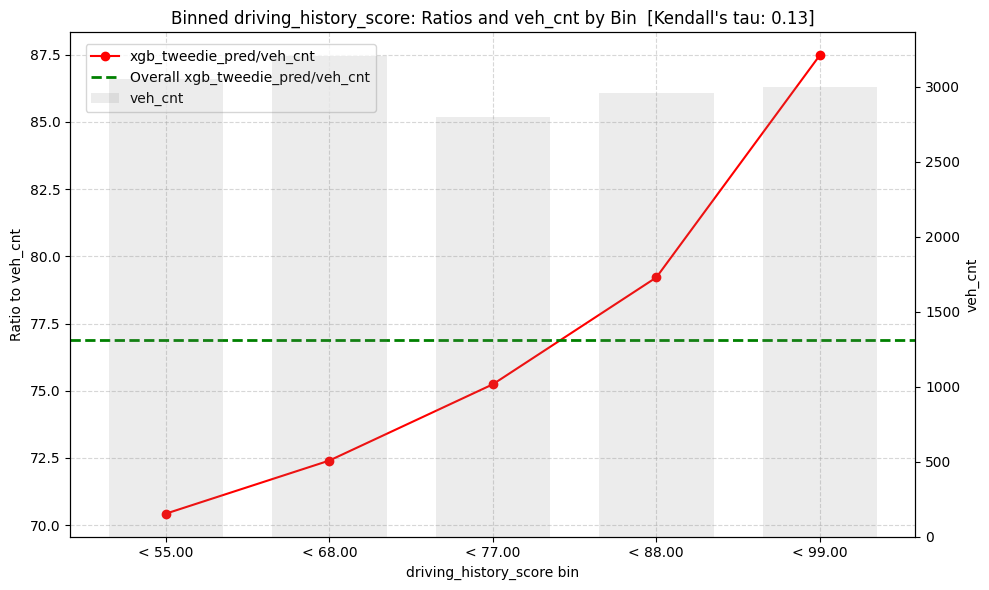

In [12]:
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
data = processed_inference_data
exp_var = 'veh_cnt' 
var_1 = 'xgb_tweedie_pred'     
var_2 = None   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=data,
    pred_var_lst=pred_lst,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all(var_1_color='red')

In [15]:
processed_inference_data.loc[processed_inference_data['bin']==9, :]
# processed_inference_data.loc[processed_inference_data['quote_number']==8294, :]

,id,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,...,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,veh_cnt,data_segment,xgb_tweedie_pred,bin
13500,15617,1.66,0.491536,HDTOP,3,F,A,4,petrol,255,...,0,weekday,6pm - 12am,6,648.321230,1,1,2|inference,109.373688,9
13501,9786,1.00,0.229084,STNWG,3,F,D,4,petrol,155,...,0,weekday,6am - 12pm,12,642.884189,0,1,2|inference,109.381142,9
13502,10034,2.06,0.084519,SEDAN,2,F,D,4,hybrid,106,...,1,weekday,12pm - 6pm,12,647.786290,0,1,2|inference,109.395958,9
13503,5939,2.42,0.815541,MIBUS,3,M,C,3,petrol,158,...,1,weekend,12pm - 6pm,12,650.563287,0,1,2|inference,109.402740,9
13504,3249,1.92,0.915413,HBACK,2,F,A,4,petrol,147,...,0,weekend,6am - 12pm,12,644.642753,1,1,2|inference,109.416199,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,20717,2.02,0.915624,SEDAN,2,F,B,2,petrol,120,...,1,weekday,12pm - 6pm,12,644.788798,1,1,2|inference,183.761688,9
14996,13367,1.24,0.492937,SEDAN,3,M,B,5,petrol,144,...,1,weekday,6am - 12pm,6,646.507970,1,1,2|inference,184.759537,9
14997,12430,1.94,0.945952,SEDAN,1,F,C,4,petrol,107,...,1,weekday,12pm - 6pm,12,642.275658,1,1,2|inference,189.773911,9
14998,4890,1.57,0.890691,SEDAN,3,F,B,3,petrol,104,...,0,weekday,12pm - 6pm,12,642.605870,1,1,2|inference,195.628876,9


#### Analysis on quote number 28490739
- credit_score  = 341   -> <span style="color:red"><b><i>   $1600 -> Credit socre is very bad (less than 560)        </i></b></span>
- veh_age       = 4     -> <span style="color:green"><b><i> $-300 -> Age of vehicle is not low (4)                   </i></b></span>
- gender        = F     -> <span style="color:green"><b><i> $-200 -> Driver is female                                </i></b></span>
- veh_value     = 1.221 -> <span style="color:green"><b><i> $-250 -> Vehicle value is not high (9.9k - 14.4k)        </i></b></span>
- area          = D     -> <span style="color:red"><b><i>    $400 -> Driver's are of residence is risker (D)         </i></b></span>
- veh_body      = UTE   -> <span style="color:red"><b><i>    $200 -> Utility vehicle type                            </i></b></span>
- traffic_index = 122.5 -> <span style="color:red"><b><i>     $30 -> Relatively heavy traffic area (119.4 - 137.3)   </i></b></span>

<span style="color:red"><b><i>Task 6: Use SHAP values and Waterfall plots to derive top reaons for individual quote. Specific to-dos are </i></b></span>
1. <span style="color:red"><b><i>Read and summarize the paper: https://arxiv.org/abs/1705.07874.</i></b></span>
2. <span style="color:red"><b><i>Read and try the SHAP value method described in this blog: https://samuel-book.github.io/samuel_shap_paper_1/xgb_10_features/03_xgb_combined_shap_key_features.html. Note that we only need to handle individual case. Global predictor impact session and other sessions are beneficial but not necessary. </i></b></span>